In [14]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan
from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI
from bmadx.bmad_torch.track_torch import particle_to_beam

from analysis import *
from stats import plot_projections_with_contours

plt.rcParams["figure.dpi"] = 300

In [2]:
# load bmadx Particle
import pickle
with open('OPAL/dogleg_beam_1e5_3mm_p1mrad_p1mrad.pkl', 'rb') as f:
    bmadx_par = pickle.load(f)
bmadx_par

Particle(x=array([-0.00099348,  0.00027404, -0.00367478, ..., -0.00959441,
       -0.00340727, -0.00110286]), px=array([ 7.97345022e-05,  3.00696572e-04,  1.50594777e-04, ...,
       -1.19931861e-04, -1.53825657e-04,  1.64514088e-04]), y=array([3.06848890e-04, 1.43730977e-03, 3.38045347e-04, ...,
       1.83633222e-03, 1.03825473e-03, 7.06008173e-05]), py=array([-4.12952086e-05, -4.28425526e-04, -1.01103722e-04, ...,
       -3.64960827e-04, -1.72518162e-04, -1.30225064e-04]), z=array([-2.36835321e-03, -7.05018929e-04, -8.57450708e-05, ...,
        1.46516262e-03,  1.32642161e-03,  1.40659919e-03]), pz=array([ 0.00017077, -0.00120938, -0.00044498, ...,  0.00018299,
        0.00021113,  0.00026717]), s=0.0, p0c=43400000.0, mc2=510998.94999999995)

In [3]:
# create bmadx torch beam
gt_beam = particle_to_beam(bmadx_par)
torch.save(gt_beam, 'gt_beam.pt')

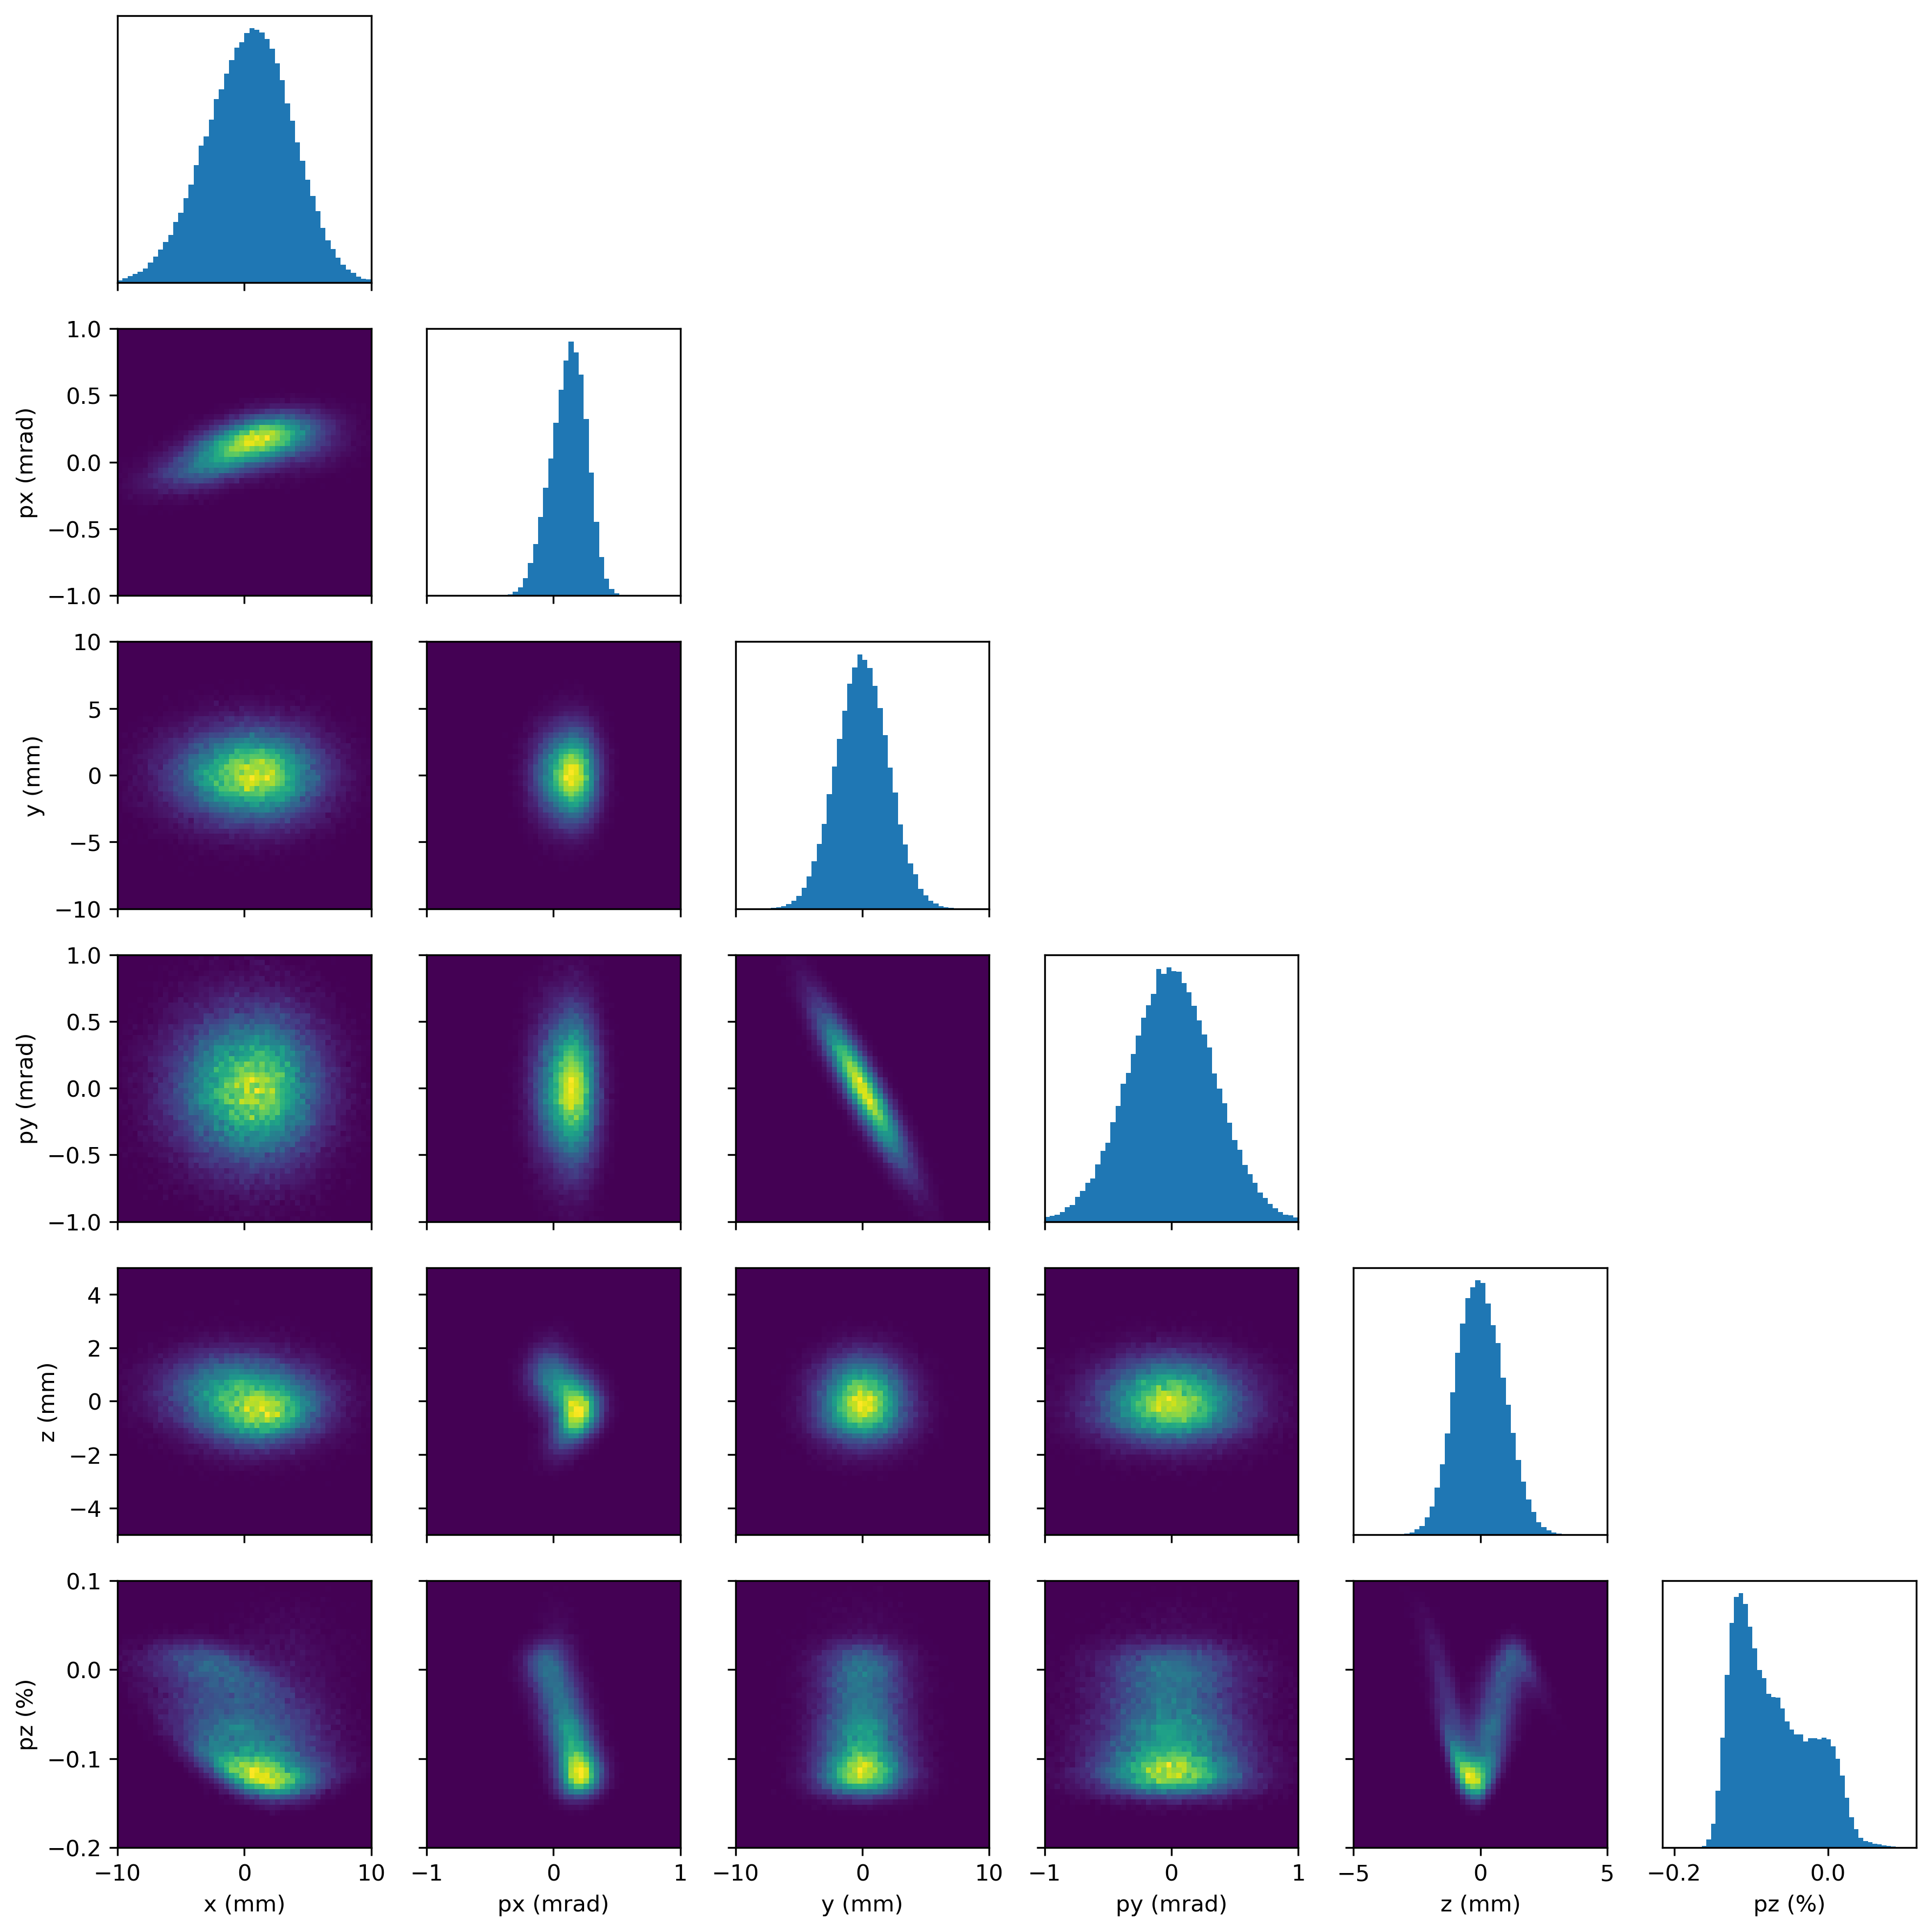

In [4]:
#plot gt beam
lims = np.array([[-10e-3, 10e-3],
                 [-1e-3, 1e-3],
                 [-10e-3, 10e-3],
                 [-1e-3, 1e-3],
                 [-5e-3, 5e-3],
                 [-2e-3, 1e-3]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

In [5]:
# triplet params obtained from triplet-opt.ipynb
k1=    0.778835
k2 =  -12.727689
k3  =  14.003951

In [6]:
# diagnostic beamline:
p0c = 43.4e6
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-2.5, 2.5, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins_x = torch.linspace(-7, 7, 200) * 1e-3
bins_y = torch.linspace(-15, 15, 200) * 1e-3
bandwidth = (bins_y[1]-bins_y[0]) / 2
screen = ImageDiagnostic(bins_x, bins_y, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


In [7]:
# generate and save train and test datasets
save_dir = '3d_scan'
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen,
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, '3d_scan_train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as '3d_scan/3d_scan_train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


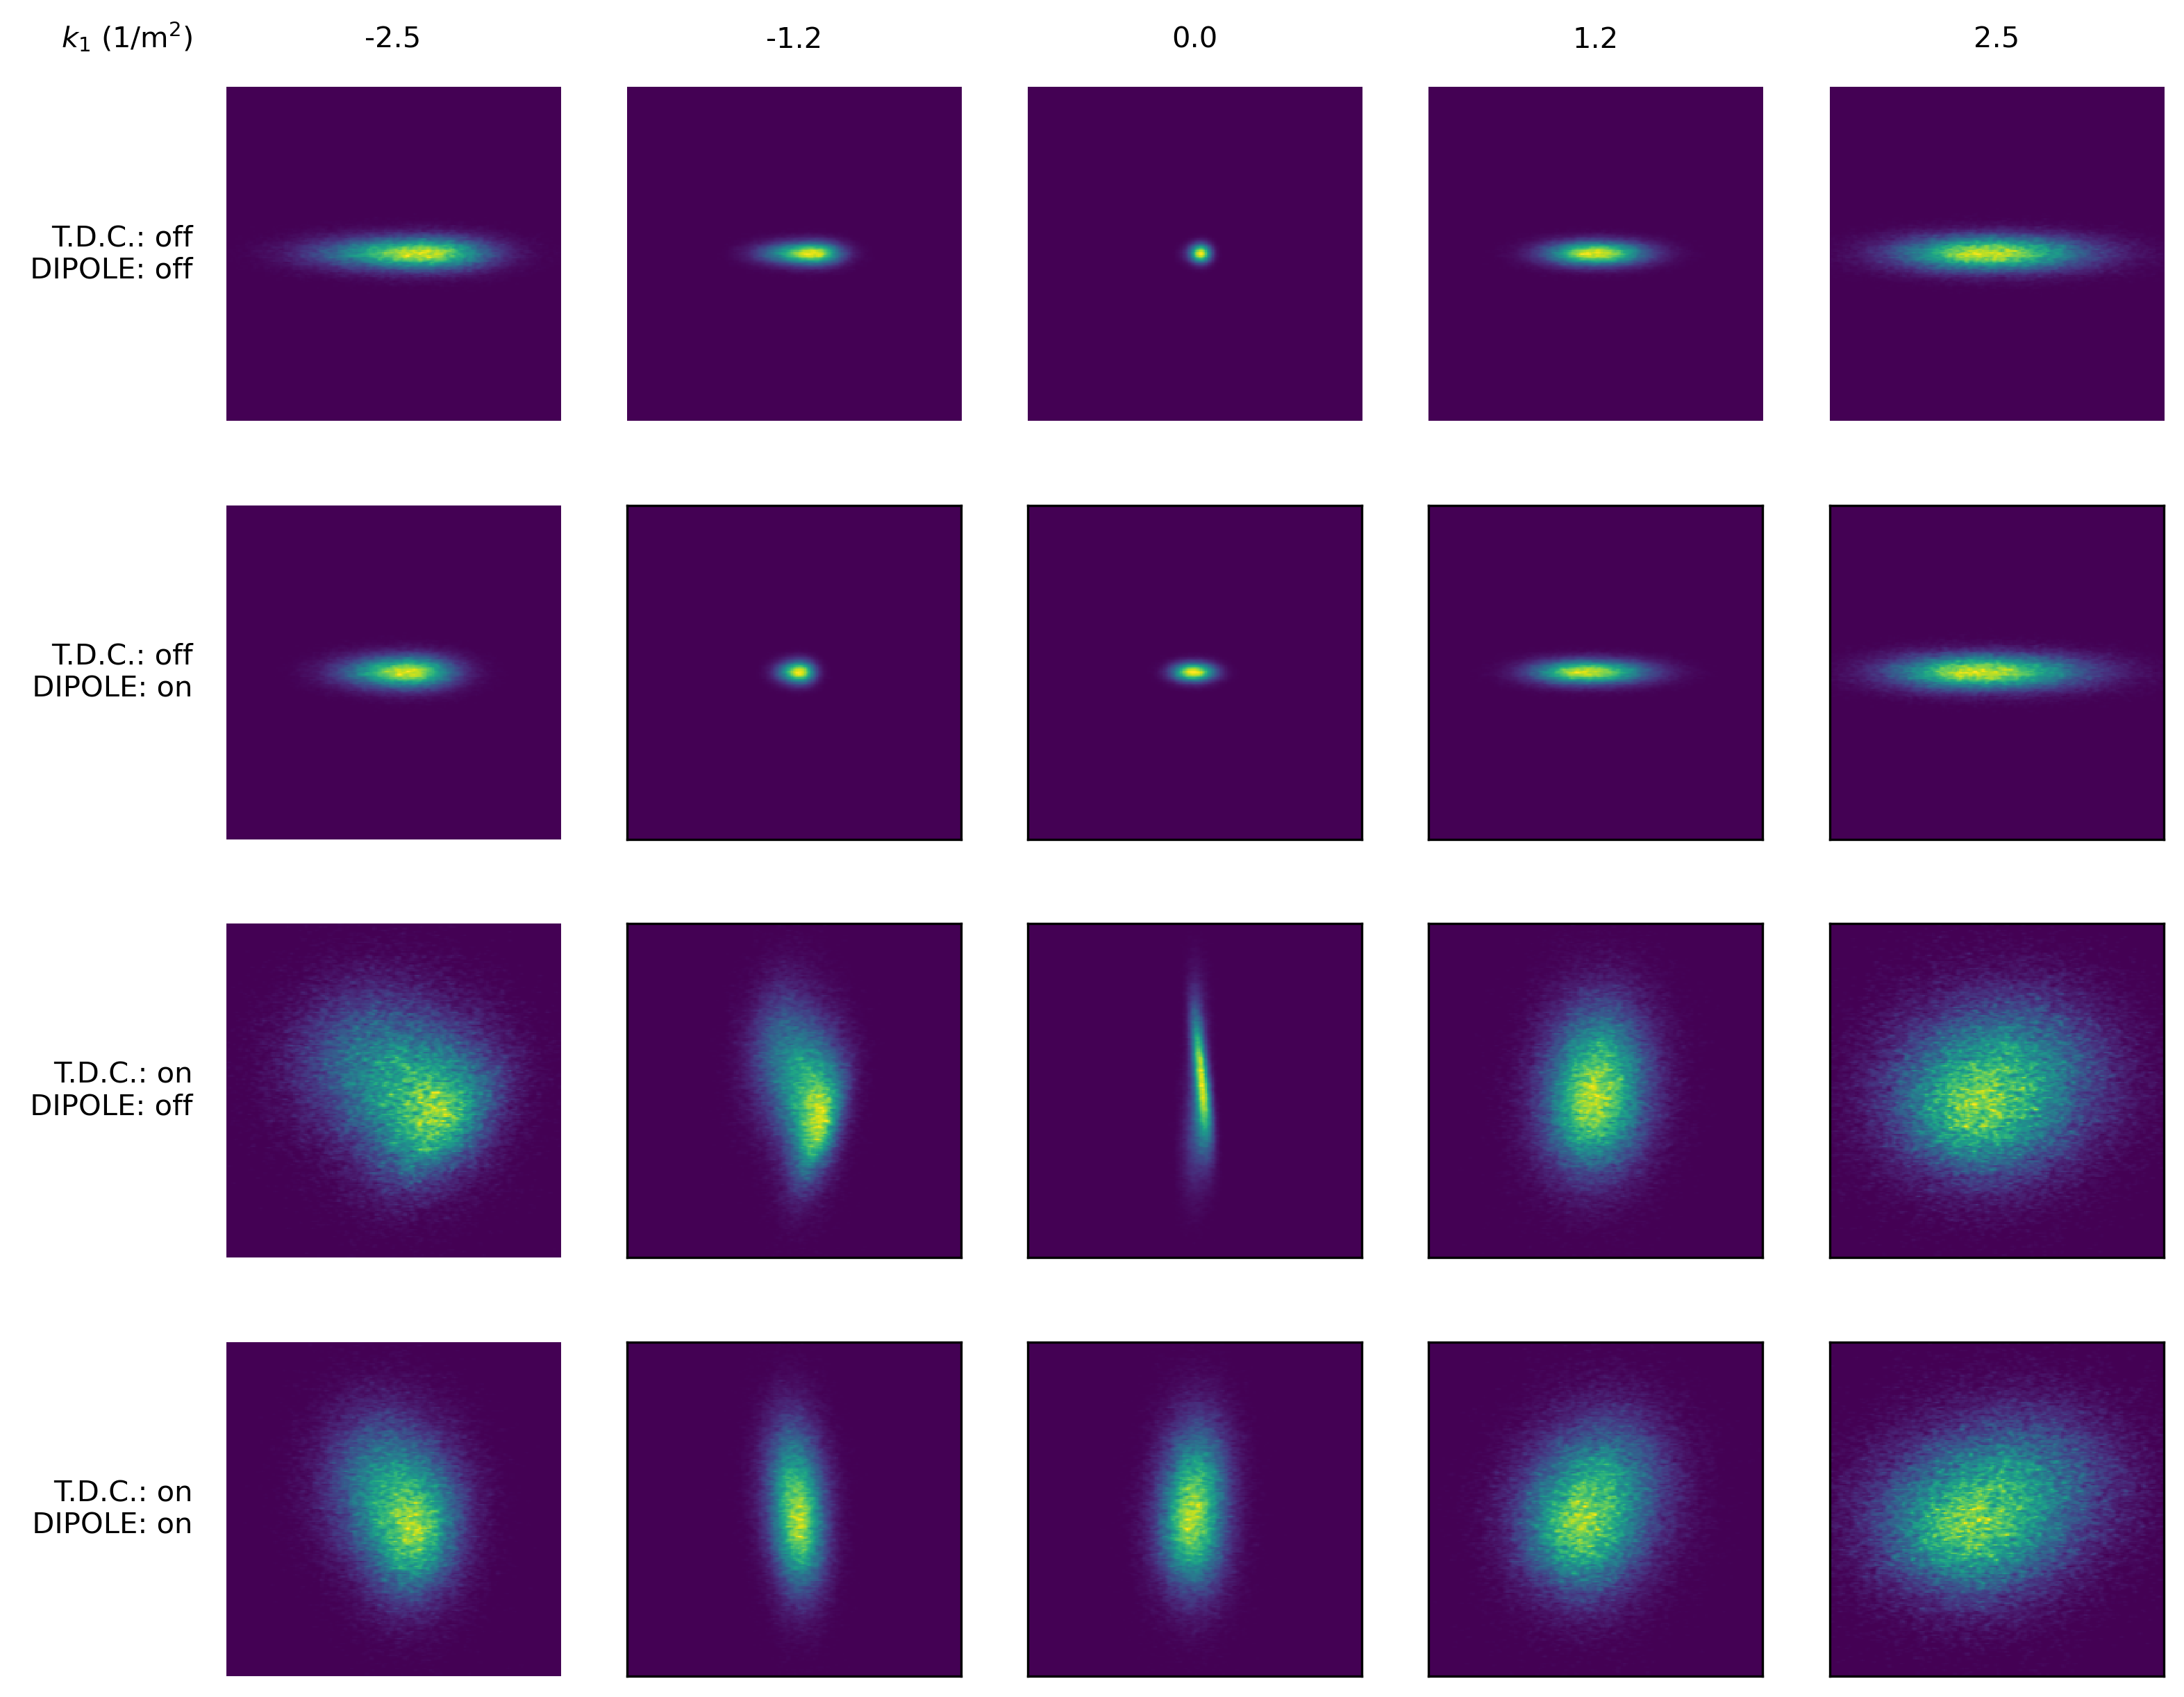

In [8]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

In [31]:
%%time

# training 
pred_beam = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 100_000,
    lambda_=1.0,
    lr=1e-12, 
    device = 'cuda'
    )

Using device: cuda
0 tensor(3.7228e-05, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(3.8196e-05, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(3.7463e-05, device='cuda:0', grad_fn=<MulBackward0>)


KeyboardInterrupt: 

In [21]:
pred_beam[0].data

tensor([[ 3.4548e-03,  3.4010e-05,  2.3741e-03, -3.8232e-04,  9.4701e-04,
         -7.9120e-04],
        [ 2.0529e-03,  8.6228e-05,  1.9048e-03, -2.0347e-04, -1.4777e-03,
         -1.4593e-03],
        [ 1.6976e-03,  1.0391e-04,  1.9118e-03, -1.4060e-04, -1.0597e-03,
         -9.2010e-04],
        ...,
        [ 3.6593e-03, -2.7450e-05, -9.1744e-04,  2.2320e-04, -1.9617e-03,
         -8.6626e-04],
        [-1.1207e-03,  6.5525e-05,  9.6154e-04, -1.1872e-04, -6.7282e-04,
         -1.3107e-03],
        [-1.2177e-03,  3.8297e-05,  1.9041e-03, -3.3465e-04,  9.7046e-04,
         -6.2123e-04]])

In [12]:
pred_par = pred_beam[0].numpy_particles()

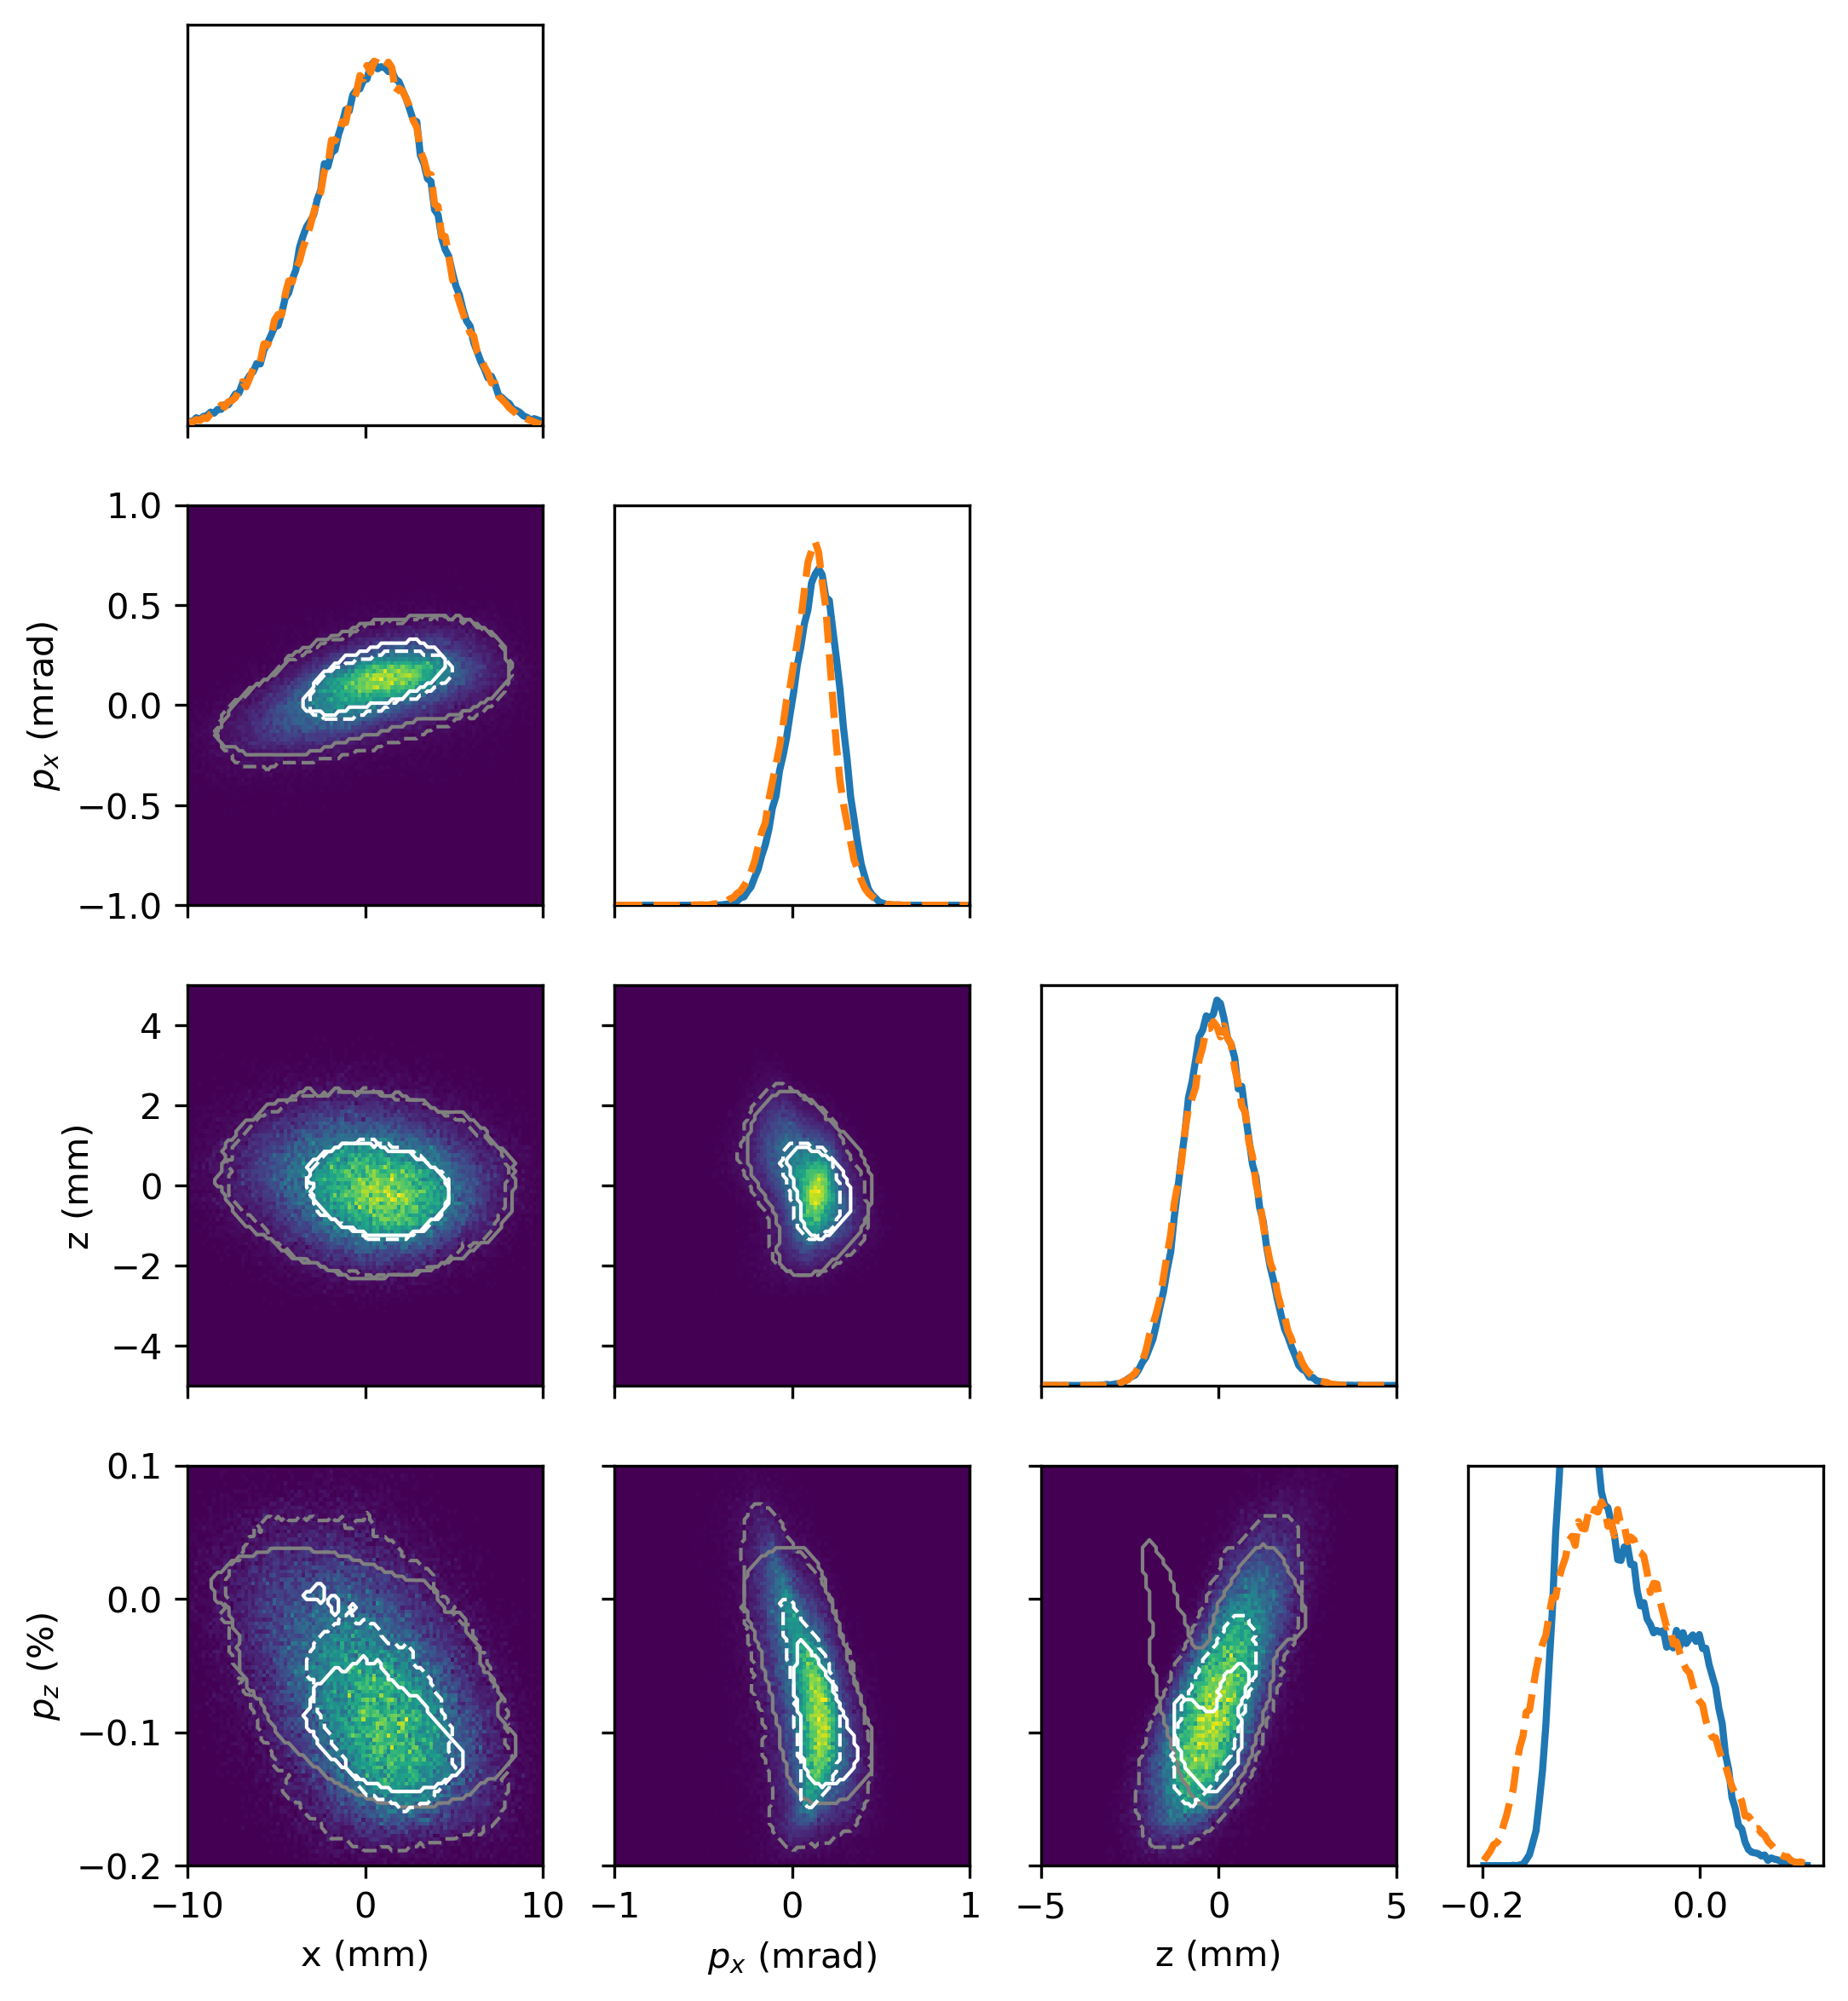

In [27]:
lims = np.array([[-10, 10],
                 [-1, 1],
                 [-5, 5],
                 [-0.2, 0.1]]) 
fig, ax = plot_projections_with_contours(
    pred_beam[0],
    ground_truth = gt_beam,
    coords=['x', 'px', 'z', 'pz'],
    custom_lims = lims,
    n_bins = 100
)
plt.show()

In [ ]:
# plots lims
z_lims = (-4, 4)
pz_lims = (-0.17, 0.10)
x_lims = (-15, 15)
px_lims= (-0.4, 0.5)
# slicing params
n_slices = 11
#z_min = pred_par.z.mean() - 2*pred_par.z.std()
#z_max = pred_par.z.mean() + 2*pred_par.z.std()
z_min = -0.00185044
z_max = 0.00185044
z_slices = np.linspace(z_min, z_max, n_slices+1)

In [ ]:
fig, ax = plot_sliced_ps_2d(pred_par, z_slices,  'z', x_lim=x_lims, px_lim=px_lims)
plt.show()
fig, ax = plot_sliced_ps_3d(pred_par, z_slices,  'z', x_lim=x_lims, px_lim=px_lims, z_lim=z_lims)
plt.show()

In [ ]:
gamma = np.sqrt( 1 + (p0c / 0.511e6)**2)
gamma

In [ ]:
emittance(pred_par, gamma)